In [1]:
import pandas as pd
import src.analytics as a
import src.constants as c
import src.visualize as v

details_path = f"{c.DATA_DIR}/details_xmatch_221219_221225.csv"
details = a.load_details(details_path, use_deny=False)

details = details[details["User Agent"] == "s3s"]
details = details[details["A Color"].notna() & details["B Color"].notna()]

details["Rule"].value_counts()

yagura    1637
hoko      1436
area      1144
asari      952
Name: Rule, dtype: int64

In [2]:
details = a.add_color_pair_column(details)

def get_first_color_win(row: pd.Series) -> bool:
    colors = row["Color Pair"].split("-")
    team = "alpha" if colors[0] == row["A Color"] else "bravo"
    return row["Win"] == team

details["1st Color Win"] = details.apply(get_first_color_win, axis=1)

In [3]:
import math

# サンプルサイズ
sample_size = details["Color Pair"].value_counts().to_frame()
sample_size

# 勝率
win_rate = details.groupby("Color Pair")["1st Color Win"].mean().to_frame()

colors = pd.concat([win_rate, sample_size], axis=1).set_axis(["Win Rate", "Sample Size"], axis=1).reset_index()
colors = colors.rename(columns={ "index": "Color Pair" })
colors = colors.sort_values("Win Rate", ascending=False)

# 95%信頼区間

def calc_lower(row: pd.Series) -> float:
    p = row["Win Rate"]
    size = row["Sample Size"]
    return p - 1.96 * math.sqrt(p * (1 - p) / size)

def calc_upper(row: pd.Series) -> float:
    p = row["Win Rate"]
    size = row["Sample Size"]
    return p + 1.96 * math.sqrt(p * (1 - p) / size)

colors["Lower"] = colors.apply(calc_lower, axis=1)
colors["Upper"] = colors.apply(calc_upper, axis=1)

# URL

def calc_url(row: pd.Series) -> str:
    color_list = row["Color Pair"].split("-")
    color_list = list(map(lambda x: x.replace("#", ""), color_list))
    url = f"https://coolors.co/palette/{'-'.join(color_list)}"
    return url

colors["Url"] = colors.apply(calc_url, axis=1)
colors

,Color Pair,Win Rate,Sample Size,Lower,Upper,Url
2,#3a0ccd-#d0bf08,0.550725,414,0.502809,0.598641,https://coolors.co/palette/3a0ccd-d0bf08
1,#343bc4-#df6624,0.532086,748,0.496327,0.567844,https://coolors.co/palette/343bc4-df6624
0,#1a1aaf-#e38d24,0.530466,837,0.496655,0.564277,https://coolors.co/palette/1a1aaf-e38d24
3,#6325cd-#bfcd41,0.524150,559,0.482749,0.565551,https://coolors.co/palette/6325cd-bfcd41
8,#c43a6e-#1bbfab,0.518367,490,0.474125,0.562609,https://coolors.co/palette/c43a6e-1bbfab
4,#6e04b6-#cd510a,0.503401,441,0.456736,0.550067,https://coolors.co/palette/6e04b6-cd510a
9,#d74b31-#1ec0ad,0.495775,355,0.443764,0.547786,https://coolors.co/palette/d74b31-1ec0ad
5,#9025c6-#cfb121,0.488818,313,0.433439,0.544197,https://coolors.co/palette/9025c6-cfb121
7,#c12d74-#2cb721,0.482201,618,0.442804,0.521597,https://coolors.co/palette/c12d74-2cb721
6,#ba30b0-#a0c937,0.467005,394,0.417741,0.516269,https://coolors.co/palette/ba30b0-a0c937


In [4]:
df = details[["Color Pair", "1st Color Win"]].copy()
order = colors["Color Pair"].to_list()
order

['#3a0ccd-#d0bf08',
 '#343bc4-#df6624',
 '#1a1aaf-#e38d24',
 '#6325cd-#bfcd41',
 '#c43a6e-#1bbfab',
 '#6e04b6-#cd510a',
 '#d74b31-#1ec0ad',
 '#9025c6-#cfb121',
 '#c12d74-#2cb721',
 '#ba30b0-#a0c937']

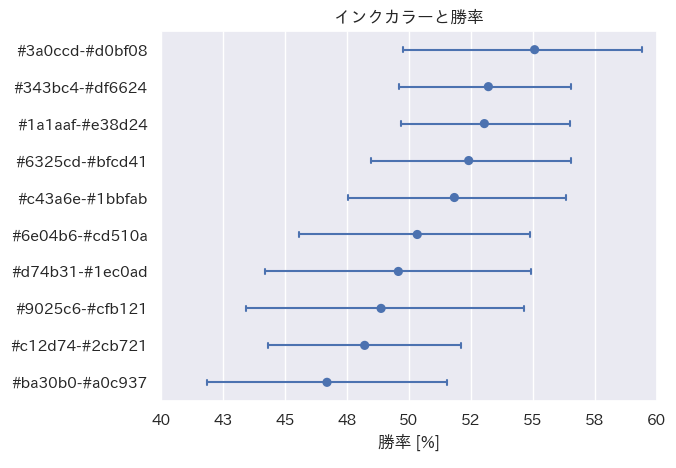

In [6]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import src.japanize as j

sns.set_theme()
j.japanize()

ax = sns.pointplot(
    data=details,
    y="Color Pair",
    x="1st Color Win",
    order=order,
    # kind="point",
    errorbar="ci",
    join=False,
    scale=0.75,
    errwidth=1.5,
    capsize=0.125,
)

xticks = ax.get_xticks()
xticklabels = list(map(lambda x: f"{round(x*100)}", xticks))

ax.set(
    title="インクカラーと勝率",
    xlabel="勝率 [%]",
    ylabel="",
    xticks=xticks,
    xticklabels=xticklabels,
    # yticklabels="",
    xlim=(0.4, 0.6),
)

im = plt.imread(f"{c.IMAGES_DIR}/wakaba.png")
img = OffsetImage(im, zoom=0.65)
img.image.axes = ax
ab = AnnotationBbox(img, (0, 0), xybox=(0, 0), frameon=False)
ax.add_artist(ab)

plt.show()